In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from transformers import BertTokenizer, BertModel
import torch
from IPython.display import display
from ipywidgets import widgets


In [2]:
# Function to generate synthetic data
def generate_synthetic_data(num_samples=300):
    genres = ['Mystery', 'Sci-Fi', 'Fantasy', 'Romance', 'Thriller']
    descriptions = ['A thrilling adventure', 'A mysterious tale', 'A futuristic journey', 'A romantic story', 'An intense drama']
    data = {'Genre': np.random.choice(genres, num_samples),
            'Description': np.random.choice(descriptions, num_samples)}
    return pd.DataFrame(data)

# Generate and display the dataset
df = generate_synthetic_data()
print(df.head())


      Genre           Description
0   Mystery      A romantic story
1   Romance     A mysterious tale
2  Thriller  A futuristic journey
3   Mystery  A futuristic journey
4   Romance  A futuristic journey


In [4]:
df

,Genre,Description
0,Mystery,A romantic story
1,Romance,A mysterious tale
2,Thriller,A futuristic journey
3,Mystery,A futuristic journey
4,Romance,A futuristic journey
...,...,...
295,Romance,A thrilling adventure
296,Thriller,An intense drama
297,Fantasy,A mysterious tale
298,Sci-Fi,An intense drama


In [5]:
# Text preprocessing and embedding extraction
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def preprocess_text(text):
    return " ".join(text.split())

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Apply preprocessing and extract embeddings
df['Processed_Description'] = df['Description'].apply(preprocess_text)
df['Embedding'] = df['Processed_Description'].apply(get_embedding)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
# K-means clustering
kmeans = KMeans(n_clusters=5, random_state=0).fit(list(df['Embedding']))
df['Cluster'] = kmeans.labels_

# Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=5).fit(list(df['Embedding']))
df['Agglo_Cluster'] = agglo.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


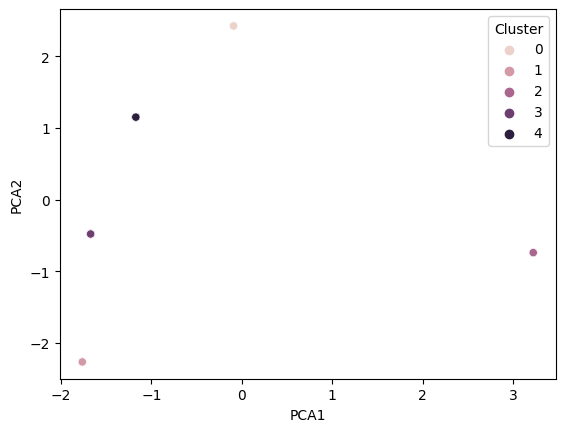

In [8]:
from sklearn.decomposition import PCA

# Reduce dimensions of embeddings for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(list(df['Embedding']))

# Create a new DataFrame for plotting
plot_df = pd.DataFrame(reduced_embeddings, columns=['PCA1', 'PCA2'])
plot_df['Cluster'] = df['Cluster']

# Scatter plot for K-means clusters
sns.scatterplot(data=plot_df, x='PCA1', y='PCA2', hue='Cluster')
plt.show()


In [9]:
# Calculate and print evaluation metrics
print("Silhouette Score for K-means:", silhouette_score(df['Embedding'].tolist(), df['Cluster']))
print("Davies-Bouldin Score for K-means:", davies_bouldin_score(df['Embedding'].tolist(), df['Cluster']))


Silhouette Score for K-means: 1.0
Davies-Bouldin Score for K-means: 1.5874967810392186e-06


In [11]:
from sklearn.metrics import calinski_harabasz_score

calinski_harabasz = calinski_harabasz_score(plot_df[['PCA1', 'PCA2']], plot_df['Cluster'])
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


Calinski-Harabasz Index: 1.870729805926239e+32


In [12]:
# You might need to install a separate package for Dunn index or implement the function manually.
# Here's a simple implementation:
from scipy.spatial.distance import euclidean

def dunn_index(X, labels):
    unique_cluster_labels = np.unique(labels)
    min_intercluster_dist = np.inf
    max_intracluster_dist = 0

    for i in unique_cluster_labels:
        intracluster_dist = np.max([euclidean(X[m], X[n]) for m in np.where(labels == i)[0] for n in np.where(labels == i)[0]])
        max_intracluster_dist = max(max_intracluster_dist, intracluster_dist)

        for j in unique_cluster_labels:
            if i != j:
                intercluster_dist = np.min([euclidean(X[m], X[n]) for m in np.where(labels == i)[0] for n in np.where(labels == j)[0]])
                min_intercluster_dist = min(min_intercluster_dist, intercluster_dist)

    return min_intercluster_dist / max_intracluster_dist

dunn_index_value = dunn_index(plot_df[['PCA1', 'PCA2']].to_numpy(), plot_df['Cluster'])
print(f"Dunn Index: {dunn_index_value}")


Dunn Index: 577398089103612.8


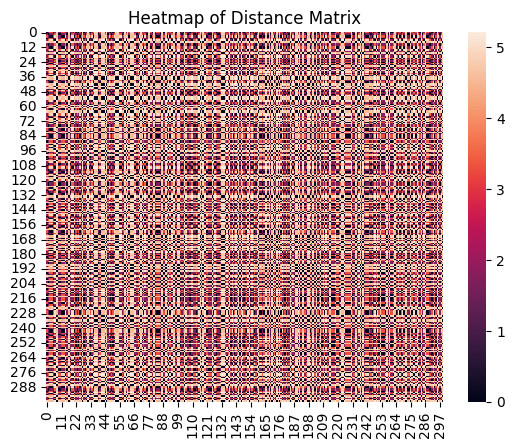

In [13]:
from scipy.spatial.distance import pdist, squareform

# Calculate distance matrix
dist_matrix = squareform(pdist(plot_df[['PCA1', 'PCA2']]))

# Plot heatmap
sns.heatmap(dist_matrix)
plt.title('Heatmap of Distance Matrix')
plt.show()


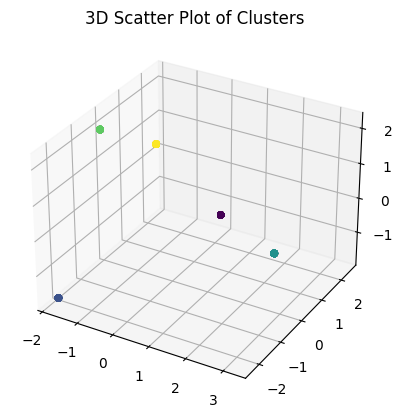

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Apply PCA with 3 components
pca_3d = PCA(n_components=3)
reduced_embeddings_3d = pca_3d.fit_transform(list(df['Embedding']))
plot_df_3d = pd.DataFrame(reduced_embeddings_3d, columns=['PCA1', 'PCA2', 'PCA3'])
plot_df_3d['Cluster'] = df['Cluster']

# 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(plot_df_3d['PCA1'], plot_df_3d['PCA2'], plot_df_3d['PCA3'], c=plot_df_3d['Cluster'])
plt.title('3D Scatter Plot of Clusters')
plt.show()


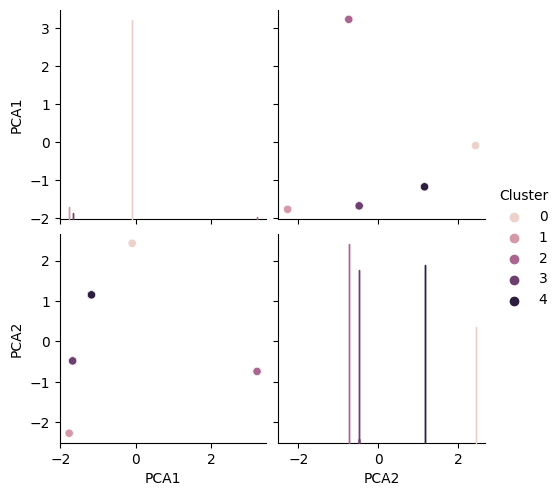

In [15]:
sns.pairplot(plot_df, hue='Cluster')
plt.show()
